# Speech Emotion Recognition - Exploratory Data Analysis

## Introduction

This notebook provides a comprehensive analysis of speech representation for emotion recognition. We'll explore the CREMA-D dataset containing emotional speech recordings and investigate various audio features.

## Import Required Libraries

All we need is here:

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

%matplotlib inline

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Visualization

There are two theories of human hearing - **place theory** (frequency-based) and **temporal theory**. In speech recognition, we see two main tendencies:
- Input spectrogram (frequencies)
- More sophisticated features like MFCC (Mel-Frequency Cepstral Coefficients), PLP

You rarely work with raw temporal data. Let's visualize some recordings!

### 1.1. Wave and Spectrogram

Choose and read a file:

In [2]:
# Define the path to the audio data
audio_path = '../data/speech_recognition/Crema/'

# List all audio files
audio_files = [f for f in os.listdir(audio_path) if f.endswith('.wav')]
print(f'Total number of audio files: {len(audio_files)}')
print(f'Sample file names: {audio_files[:5]}')

Total number of audio files: 7442
Sample file names: ['1048_IWW_HAP_XX.wav', '1079_IEO_SAD_HI.wav', '1047_TIE_FEA_XX.wav', '1081_IEO_ANG_LO.wav', '1090_IEO_FEA_LO.wav']


In [3]:
# Select a sample file
filename = '1027_IEO_HAP_MD.wav'
sample_rate, samples = wavfile.read(audio_path + filename)

print(f'Sample rate: {sample_rate} Hz')
print(f'Audio shape: {samples.shape}')
print(f'Duration: {len(samples) / sample_rate:.2f} seconds')

Sample rate: 16000 Hz
Audio shape: (42175,)
Duration: 2.64 seconds


Define a function that calculates spectrogram.

Note that we are taking the logarithm of spectrogram values. It makes our plot much clearer, and moreover, it is strictly connected to the way people hear. We need to assure that there are no 0 values as input to the logarithm.

In [4]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    """
    Calculate log spectrogram from audio signal
    
    Parameters:
    -----------
    audio : array
        Audio signal
    sample_rate : int
        Sampling rate
    window_size : int
        Window size in milliseconds
    step_size : int
        Step size in milliseconds
    eps : float
        Small value to avoid log(0)
    
    Returns:
    --------
    freqs : array
        Frequency bins
    times : array
        Time bins
    log_spec : array
        Log spectrogram
    """
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Frequencies are in the range (0, sample_rate/2) according to Nyquist theorem.

Let's plot it:

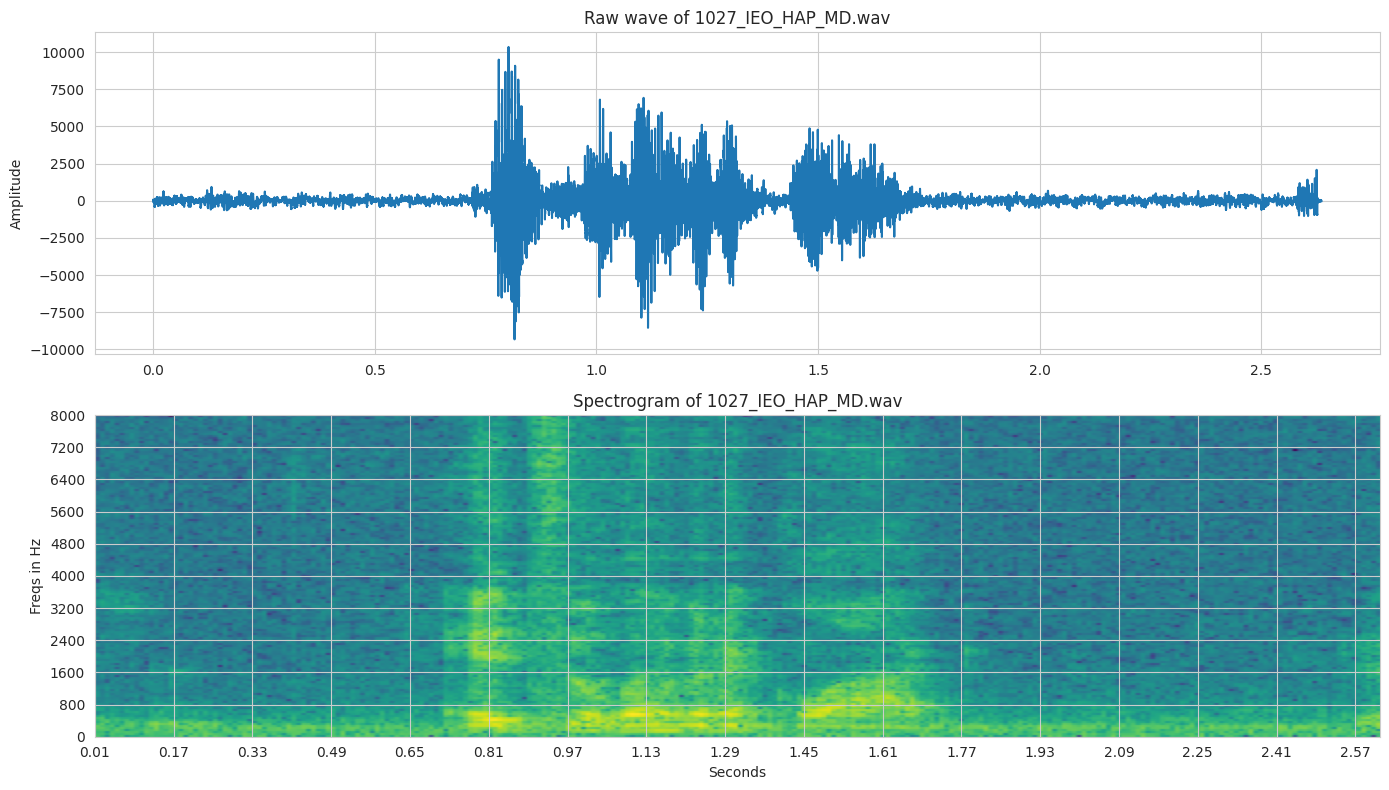

In [5]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title(f'Raw wave of {filename}')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(samples)/sample_rate, len(samples)), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()],
           cmap='viridis')
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title(f'Spectrogram of {filename}')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')
plt.tight_layout()
plt.show()

Listen to the audio file:

In [6]:
ipd.Audio(samples, rate=sample_rate)

If we use spectrogram as input features for NN, we have to remember to normalize features. We need to normalize over all the dataset; here's an example just for one file:

In [7]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram_normalized = (spectrogram - mean) / std

print(f'Original spectrogram shape: {spectrogram.shape}')
print(f'Normalized mean: {np.mean(spectrogram_normalized):.4f}')
print(f'Normalized std: {np.std(spectrogram_normalized):.4f}')

Original spectrogram shape: (262, 161)
Normalized mean: 0.0000
Normalized std: 1.0000


### 1.2. MFCC

**MFCC (Mel-Frequency Cepstral Coefficients)** are well prepared to imitate human hearing properties. 

You can calculate Mel power spectrogram and MFCC using the librosa package.

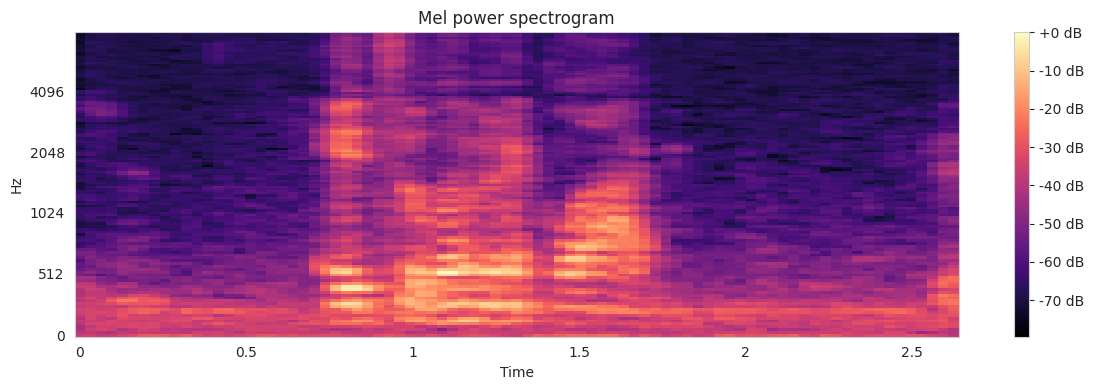

In [8]:
# Calculate Mel spectrogram
S = librosa.feature.melspectrogram(y=samples.astype(float), sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()

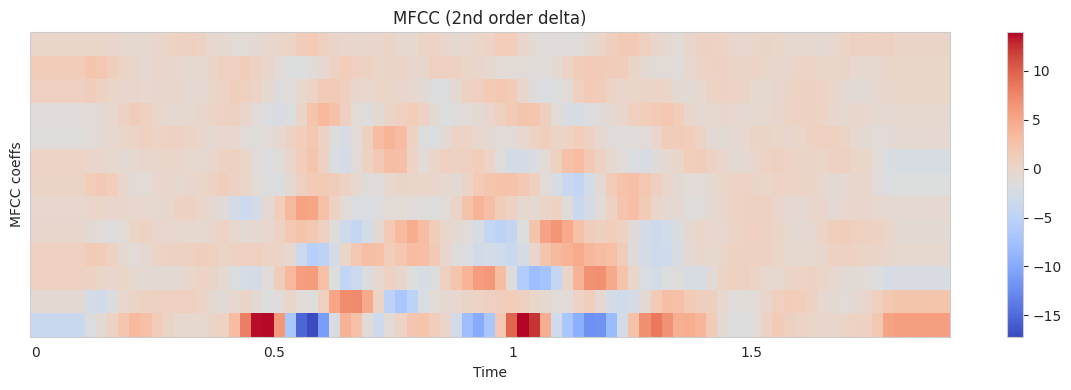

In [9]:
# Calculate MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Calculate delta (velocity) and delta-delta (acceleration)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc, x_axis='time')
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC (2nd order delta)')
plt.colorbar()
plt.tight_layout()
plt.show()

In classical, state-of-the-art systems, **MFCC** or similar features are taken as input instead of spectrograms.

However, in end-to-end (neural-network based) systems, the most common input features are raw spectrograms or mel power spectrograms. MFCC decorrelates features, but NNs deal with correlated features well.

**It is your decision which to choose!**

### 1.3. Spectrogram in 3D

Have you ever seen a spectrogram in 3D?

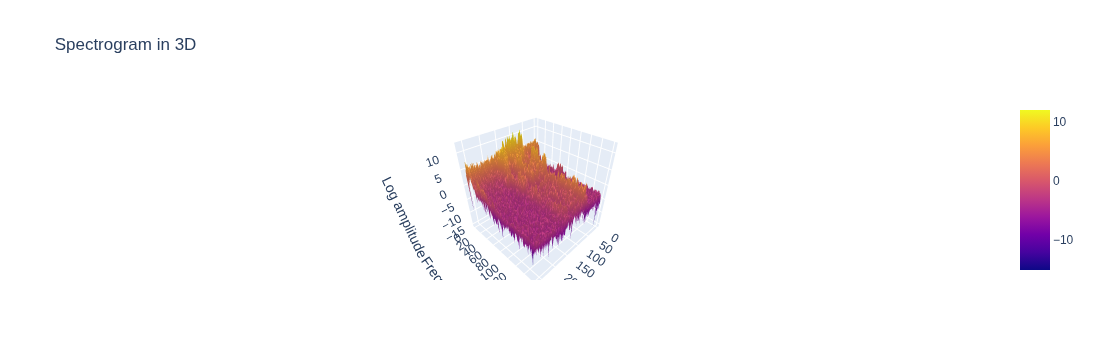

In [10]:
data = [go.Surface(z=spectrogram.T)]
layout = go.Layout(
    title='Spectrogram in 3D',
    scene = dict(
        yaxis = dict(title='Frequencies'),
        xaxis = dict(title='Time'),
        zaxis = dict(title='Log amplitude'),
    ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 1.4. Resampling - Dimensionality Reduction

Another way to reduce the dimensionality of our data is to resample recordings.

We could resample our dataset to 8kHz. We will discard some information that shouldn't be important, and we'll reduce the size of the data. The most speech-related frequencies are presented in smaller bands.

Define FFT function:

In [11]:
def custom_fft(y, fs):
    """
    Calculate Fast Fourier Transform
    
    Parameters:
    -----------
    y : array
        Signal
    fs : int
        Sampling frequency
        
    Returns:
    --------
    xf : array
        Frequency bins
    vals : array
        FFT magnitude values
    """
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is symmetrical, so we take just the first half
    # FFT is also complex, so we take just the real part (abs)
    return xf, vals

In [12]:
# Read a sample file and resample
filename2 = '1027_IOM_HAP_XX.wav'
new_sample_rate = 8000

sample_rate_orig, samples_orig = wavfile.read(audio_path + filename2)
resampled = signal.resample(samples_orig, int(new_sample_rate/sample_rate_orig * samples_orig.shape[0]))

print(f'Original sample rate: {sample_rate_orig} Hz, shape: {samples_orig.shape}')
print(f'Resampled rate: {new_sample_rate} Hz, shape: {resampled.shape}')

Original sample rate: 16000 Hz, shape: (38972,)
Resampled rate: 8000 Hz, shape: (19486,)


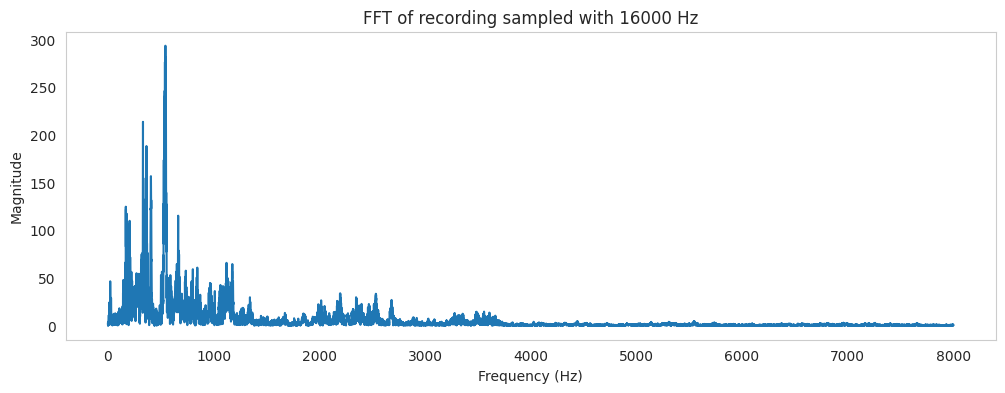

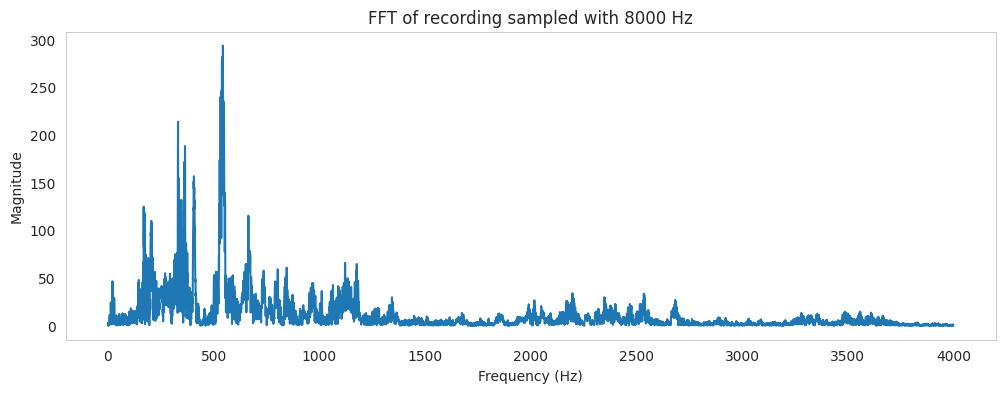

In [13]:
# Compare FFT of original and resampled
xf, vals = custom_fft(samples_orig, sample_rate_orig)
plt.figure(figsize=(12, 4))
plt.title(f'FFT of recording sampled with {sample_rate_orig} Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

xf_res, vals_res = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title(f'FFT of recording sampled with {new_sample_rate} Hz')
plt.plot(xf_res, vals_res)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

Notice that there is almost no information above 4000 Hz in the original signal. This is how we can reduce dataset size!

## 2. Dataset Investigation

Now let's investigate our dataset structure and distribution.

### 2.1. Parse Filename Information

The CREMA-D dataset uses a structured filename format: `ActorID_Sentence_Emotion_Intensity.wav`

In [14]:
# Parse filenames to extract metadata
def parse_filename(filename):
    """
    Parse CREMA-D filename format: ActorID_Sentence_Emotion_Intensity.wav
    
    Emotion codes:
    - ANG: Anger
    - DIS: Disgust
    - FEA: Fear
    - HAP: Happy
    - NEU: Neutral
    - SAD: Sadness
    """
    parts = filename.replace('.wav', '').split('_')
    return {
        'filename': filename,
        'actor_id': parts[0],
        'sentence': parts[1],
        'emotion': parts[2],
        'intensity': parts[3] if len(parts) > 3 else 'XX'
    }

# Create a DataFrame with all file information
file_data = [parse_filename(f) for f in audio_files]
df = pd.DataFrame(file_data)

print(f'Total recordings: {len(df)}')
print(f'\nFirst few entries:')
df.head()

Total recordings: 7442

First few entries:


,filename,actor_id,sentence,emotion,intensity
0,1048_IWW_HAP_XX.wav,1048,IWW,HAP,XX
1,1079_IEO_SAD_HI.wav,1079,IEO,SAD,HI
2,1047_TIE_FEA_XX.wav,1047,TIE,FEA,XX
3,1081_IEO_ANG_LO.wav,1081,IEO,ANG,LO
4,1090_IEO_FEA_LO.wav,1090,IEO,FEA,LO


### 2.2. Emotion Distribution

Let's visualize the distribution of emotions in the dataset:

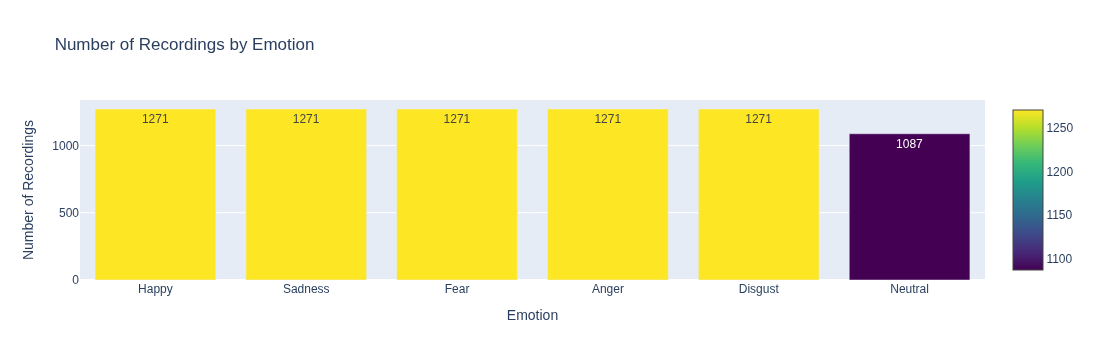

In [15]:
# Count recordings by emotion
emotion_counts = df['emotion'].value_counts()

# Create emotion name mapping
emotion_names = {
    'ANG': 'Anger',
    'DIS': 'Disgust',
    'FEA': 'Fear',
    'HAP': 'Happy',
    'NEU': 'Neutral',
    'SAD': 'Sadness'
}

# Plot distribution using plotly
trace = go.Bar(
    x=[emotion_names.get(e, e) for e in emotion_counts.index],
    y=emotion_counts.values,
    marker=dict(color=emotion_counts.values, colorscale='Viridis', showscale=True),
    text=emotion_counts.values,
    textposition='auto'
)
layout = go.Layout(
    title='Number of Recordings by Emotion',
    xaxis=dict(title='Emotion'),
    yaxis=dict(title='Number of Recordings')
)
py.iplot(go.Figure(data=[trace], layout=layout))

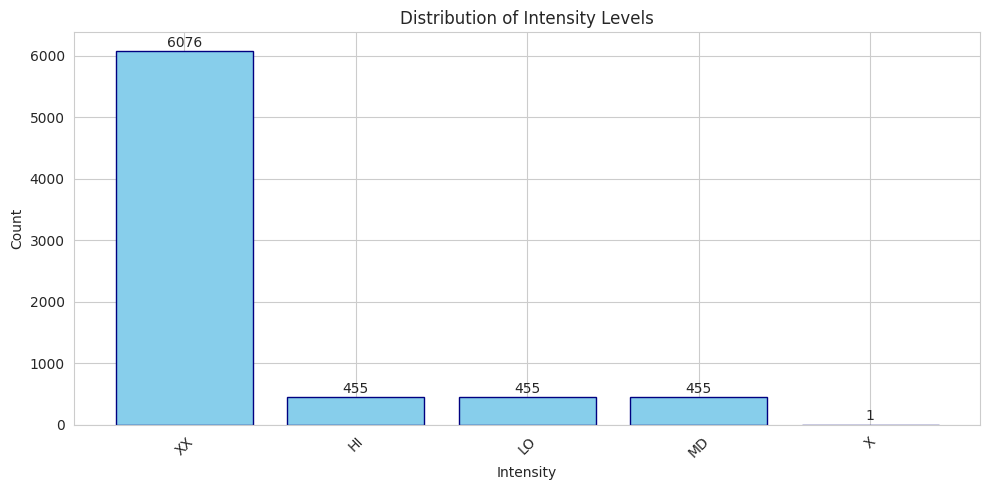

In [16]:
# Intensity distribution
intensity_counts = df['intensity'].value_counts()

plt.figure(figsize=(10, 5))
plt.bar(intensity_counts.index, intensity_counts.values, color='skyblue', edgecolor='navy')
plt.title('Distribution of Intensity Levels')
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.xticks(rotation=45)
for i, v in enumerate(intensity_counts.values):
    plt.text(i, v + 20, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()

Dataset appears balanced across emotions, which is good for training!

### 2.3. Mean Spectrograms and FFT by Emotion

Let's plot mean FFT and spectrograms for each emotion to see if there are distinguishable patterns:

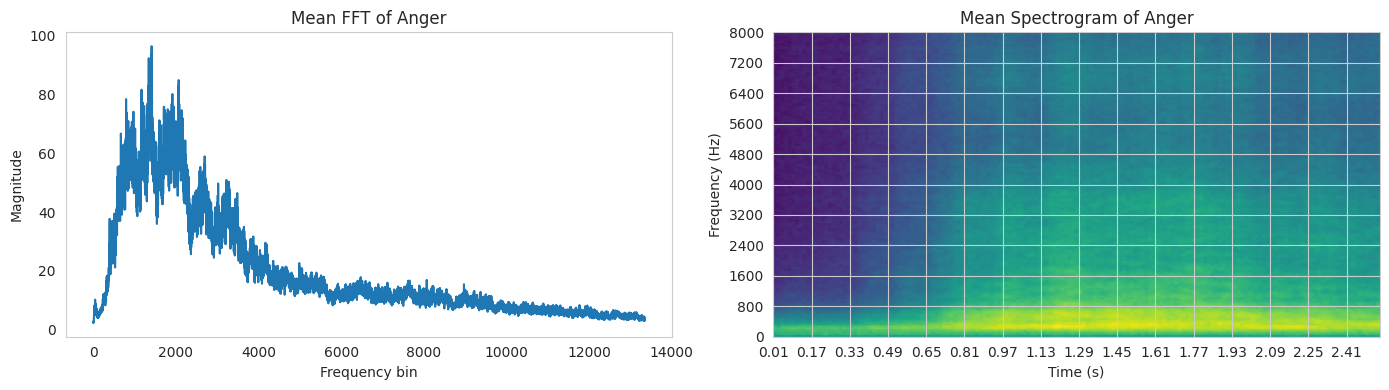

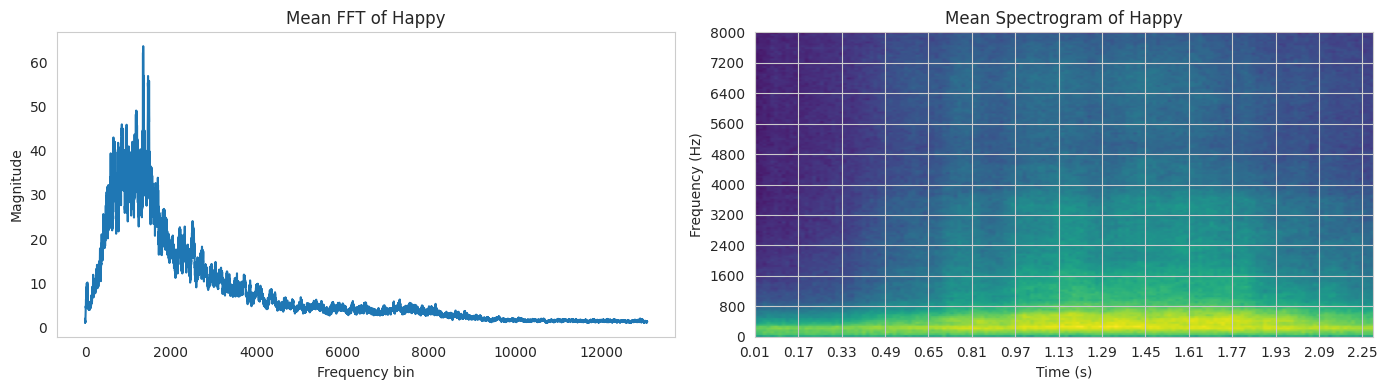

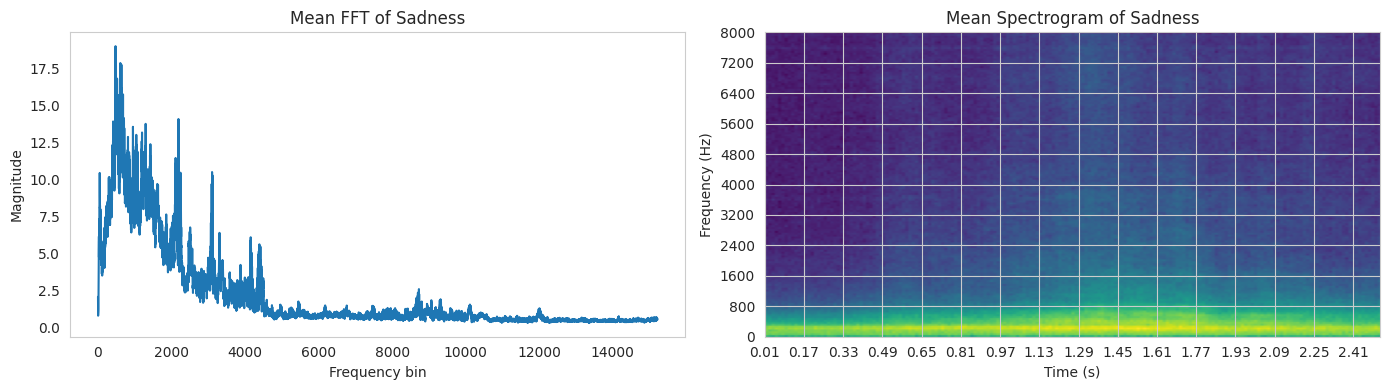

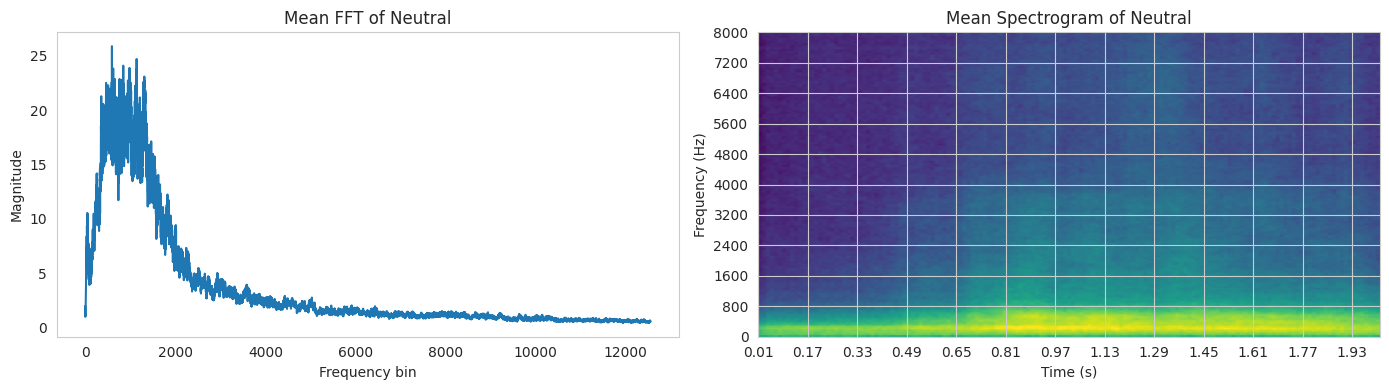

In [17]:
# Select a few emotions to analyze
emotions_to_analyze = ['ANG', 'HAP', 'SAD', 'NEU']

for emotion in emotions_to_analyze:
    vals_all = []
    spec_all = []
    
    # Get files for this emotion
    emotion_files = df[df['emotion'] == emotion]['filename'].values
    
    # Sample up to 50 files
    for wav_file in emotion_files[:50]:
        try:
            sr, samples_emo = wavfile.read(audio_path + wav_file)
            
            # Skip if too short
            if len(samples_emo) < sr:
                continue
                
            # Calculate FFT
            xf, vals = custom_fft(samples_emo, sr)
            vals_all.append(vals)
            
            # Calculate spectrogram
            freqs, times, spec = log_specgram(samples_emo, sr)
            spec_all.append(spec)
        except:
            continue
    
    if len(vals_all) == 0:
        continue
    
    # Find minimum dimensions to ensure all arrays have same shape
    min_fft_len = min([v.shape[0] for v in vals_all])
    min_spec_len = min([s.shape[0] for s in spec_all])
    
    # Truncate all arrays to minimum length
    vals_all = [v[:min_fft_len] for v in vals_all]
    spec_all = [s[:min_spec_len] for s in spec_all]
    
    # Plot mean FFT and spectrogram
    plt.figure(figsize=(14, 4))
    
    plt.subplot(121)
    plt.title(f'Mean FFT of {emotion_names[emotion]}')
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.xlabel('Frequency bin')
    plt.ylabel('Magnitude')
    plt.grid()
    
    plt.subplot(122)
    plt.title(f'Mean Spectrogram of {emotion_names[emotion]}')
    mean_spec = np.mean(np.array(spec_all), axis=0)
    plt.imshow(mean_spec.T, aspect='auto', origin='lower', cmap='viridis',
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    
    plt.tight_layout()
    plt.show()

We can see that mean FFT looks different for different emotions! Mean spectrograms also show temporal patterns that distinguish emotions.

### 2.4. Recording Length Analysis

Let's check the duration distribution:

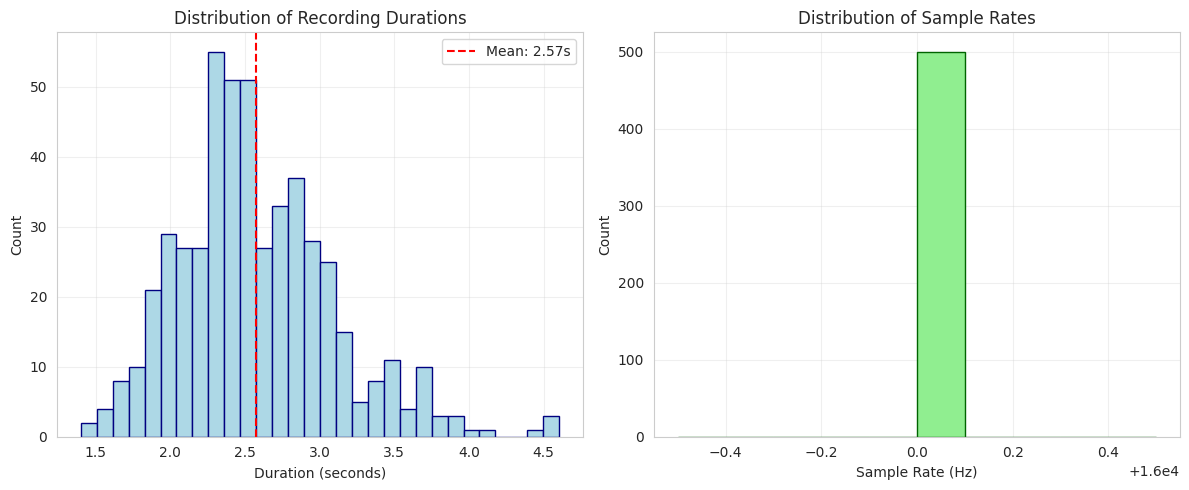

Duration statistics:
  Mean: 2.57 seconds
  Std: 0.52 seconds
  Min: 1.40 seconds
  Max: 4.60 seconds

Most common sample rate: 16000 Hz


In [18]:
# Get duration of all files (sample first 500 for speed)
durations = []
sample_rates_list = []

for wav_file in audio_files[:500]:
    try:
        sr, samples_dur = wavfile.read(audio_path + wav_file)
        duration = len(samples_dur) / sr
        durations.append(duration)
        sample_rates_list.append(sr)
    except:
        continue

# Plot duration distribution
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.hist(durations, bins=30, color='lightblue', edgecolor='navy')
plt.title('Distribution of Recording Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.axvline(np.mean(durations), color='red', linestyle='--', label=f'Mean: {np.mean(durations):.2f}s')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(122)
plt.hist(sample_rates_list, bins=10, color='lightgreen', edgecolor='darkgreen')
plt.title('Distribution of Sample Rates')
plt.xlabel('Sample Rate (Hz)')
plt.ylabel('Count')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Duration statistics:')
print(f'  Mean: {np.mean(durations):.2f} seconds')
print(f'  Std: {np.std(durations):.2f} seconds')
print(f'  Min: {np.min(durations):.2f} seconds')
print(f'  Max: {np.max(durations):.2f} seconds')
print(f'\nMost common sample rate: {max(set(sample_rates_list), key=sample_rates_list.count)} Hz')

### 2.5. Frequency Components Across Emotions

Let's examine how specific frequency components vary across emotions using violin plots:

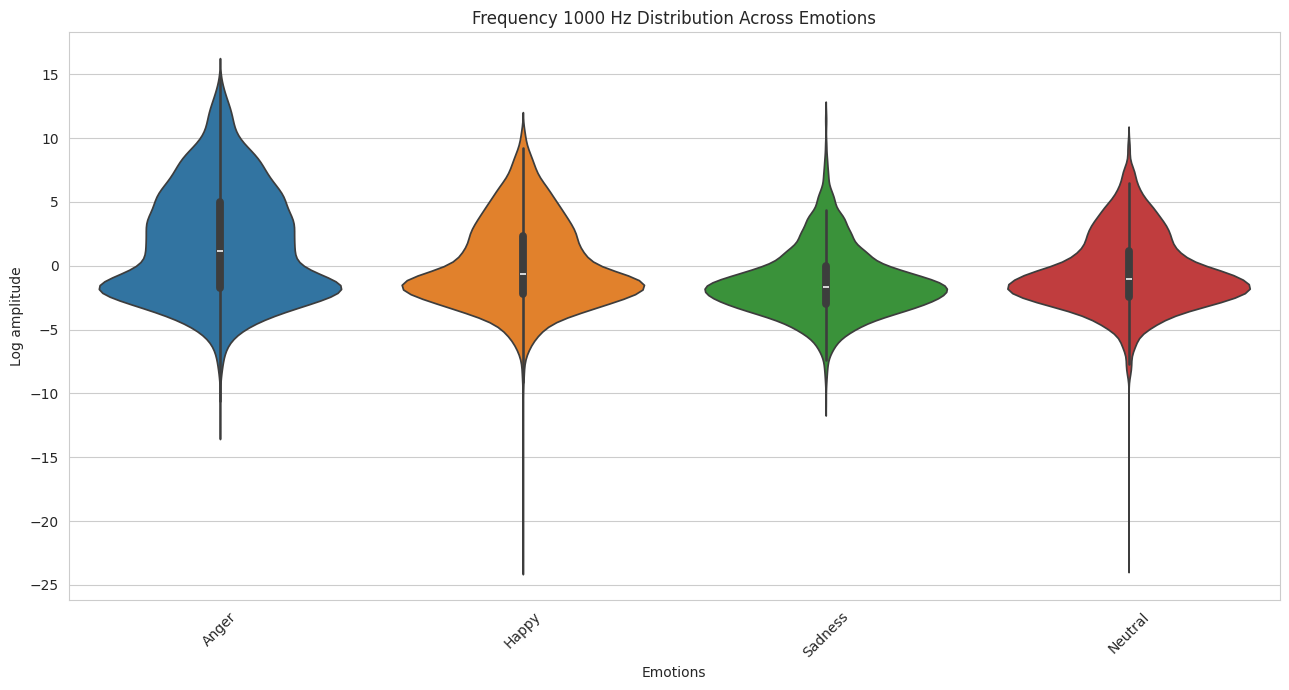

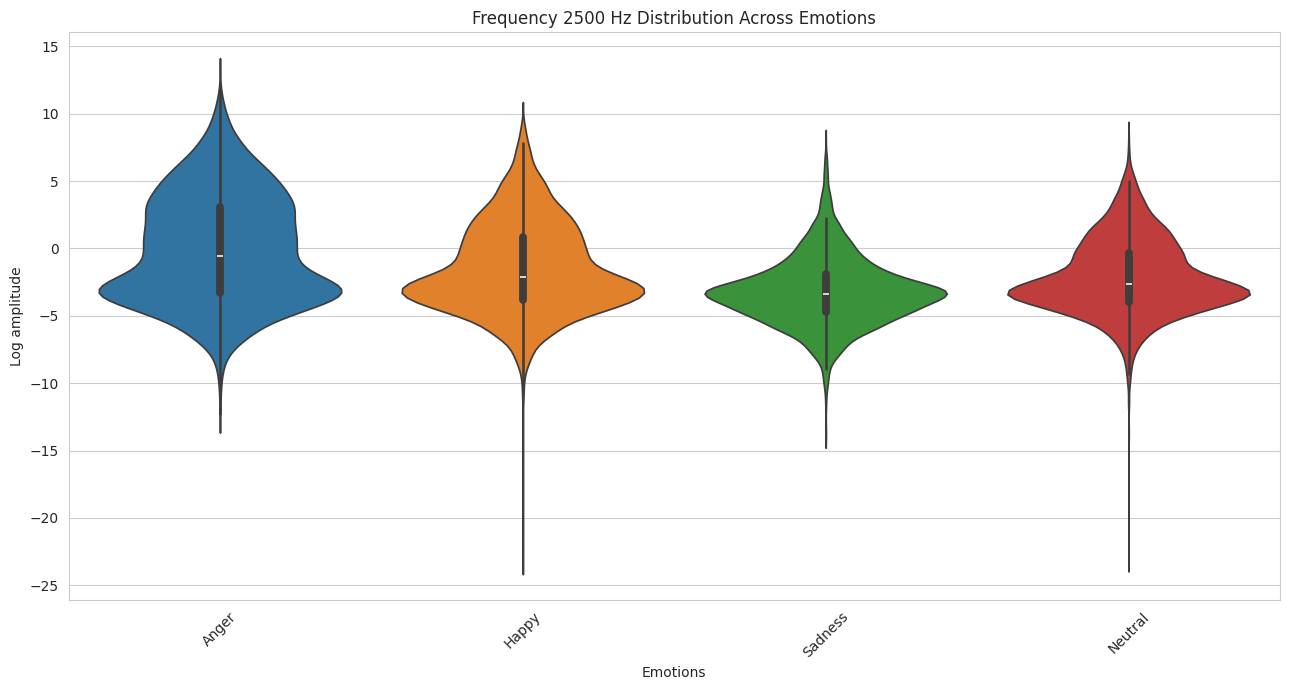

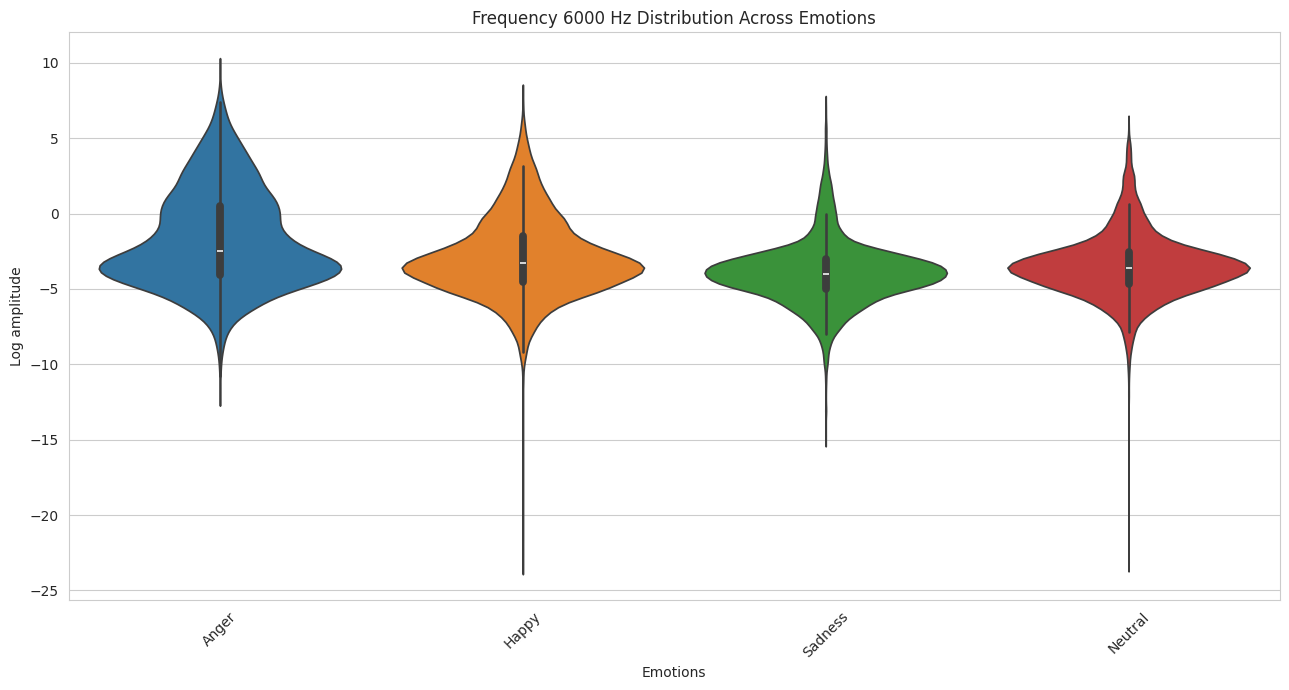

In [19]:
def violinplot_frequency(emotions, freq_ind, sample_size=30):
    """
    Plot violinplots for given emotions and frequency freq_ind
    """
    spec_all = []
    emotion_labels = []
    
    for emotion in emotions:
        emotion_spec = []
        emotion_files = df[df['emotion'] == emotion]['filename'].values
        
        for wav_file in emotion_files[:sample_size]:
            try:
                sr, samples_vio = wavfile.read(audio_path + wav_file)
                freqs, times, spec = log_specgram(samples_vio, sr)
                emotion_spec.extend(spec[:, freq_ind])
            except:
                continue
        
        spec_all.append(emotion_spec)
        emotion_labels.append(emotion_names.get(emotion, emotion))
    
    # Make all equal length
    min_len = min([len(s) for s in spec_all])
    spec_all = [s[:min_len] for s in spec_all]
    
    plt.figure(figsize=(13, 7))
    plt.title(f'Frequency {freqs[freq_ind]:.0f} Hz Distribution Across Emotions')
    plt.ylabel('Log amplitude')
    plt.xlabel('Emotions')
    
    df_violin = pd.DataFrame(np.array(spec_all).T, columns=emotion_labels)
    sns.violinplot(data=df_violin)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for different frequency indices
violinplot_frequency(emotions_to_analyze, 20)
violinplot_frequency(emotions_to_analyze, 50)
violinplot_frequency(emotions_to_analyze, 120)

### 2.6. Anomaly Detection

We should check if there are any recordings that stand out from the rest. We'll use PCA for dimensionality reduction and visualize in 3D:

In [20]:
# Collect FFT for sample of files
fft_all = []
names = []
emotions_list = []

sample_files = audio_files[:300]  # Sample 300 files for speed

for wav_file in sample_files:
    try:
        sr, samples_anom = wavfile.read(audio_path + wav_file)
        
        # Pad if necessary
        if samples_anom.shape[0] < sr:
            samples_anom = np.append(samples_anom, np.zeros((sr - samples_anom.shape[0],)))
        
        # Calculate FFT
        x, val = custom_fft(samples_anom, sr)
        fft_all.append(val)
        names.append(wav_file)
        
        # Get emotion from filename
        emotion = parse_filename(wav_file)['emotion']
        emotions_list.append(emotion_names.get(emotion, emotion))
    except:
        continue

# Find minimum FFT length to ensure all arrays have same shape
min_fft_len = min([f.shape[0] for f in fft_all])

# Truncate all FFT arrays to minimum length
fft_all = [f[:min_fft_len] for f in fft_all]

fft_all = np.array(fft_all)

# Normalization
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0)

# Dimensionality reduction with PCA
pca = PCA(n_components=3)
fft_pca = pca.fit_transform(fft_all)

print(f'PCA explained variance ratio: {pca.explained_variance_ratio_}')
print(f'Total variance explained: {sum(pca.explained_variance_ratio_):.2%}')

PCA explained variance ratio: [0.44716982 0.04780924 0.04124033]
Total variance explained: 53.62%


/home/stelian/Desktop/bigdata/big_data_24projects/venv/lib/python3.12/site-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




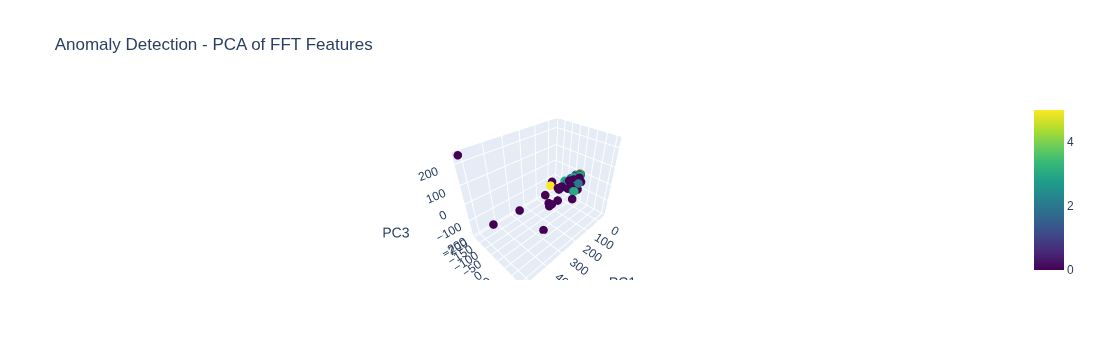

In [21]:
# Interactive 3D plot
def interactive_3d_plot(data, names, emotions):
    emotion_to_color = {emotion: idx for idx, emotion in enumerate(emotion_names.values())}
    colors = [emotion_to_color.get(e, 0) for e in emotions]
    scatt = go.Scatter3d(
        x=data[:, 0], 
        y=data[:, 1], 
        z=data[:, 2], 
        mode='markers',
        text=[f'{n}<br>{e}' for n, e in zip(names, emotions)],
        marker=dict(
            size=5,
            color=colors,
            colorscale='Viridis',
            showscale=True
        )
    )
    data_plot = go.Data([scatt])
    layout = go.Layout(
        title="Anomaly Detection - PCA of FFT Features",
        scene=dict(
            xaxis=dict(title='PC1'),
            yaxis=dict(title='PC2'),
            zaxis=dict(title='PC3')
        )
    )
    figure = go.Figure(data=data_plot, layout=layout)
    py.iplot(figure)

interactive_3d_plot(fft_pca, names, emotions_list)

Notice if there are any points that lie far away from the rest - these could be anomalies or outliers in the dataset.

### 2.7. Compare Different Speakers

Let's see how different speakers sound for the same emotion:

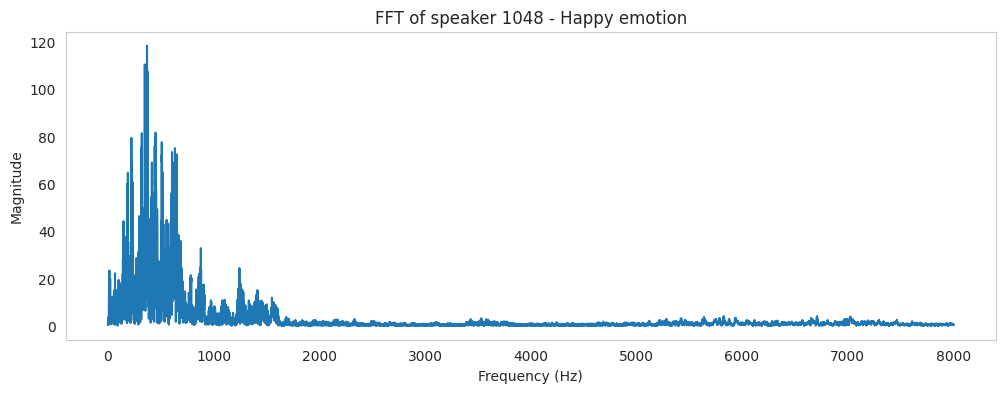

Speaker 1048:


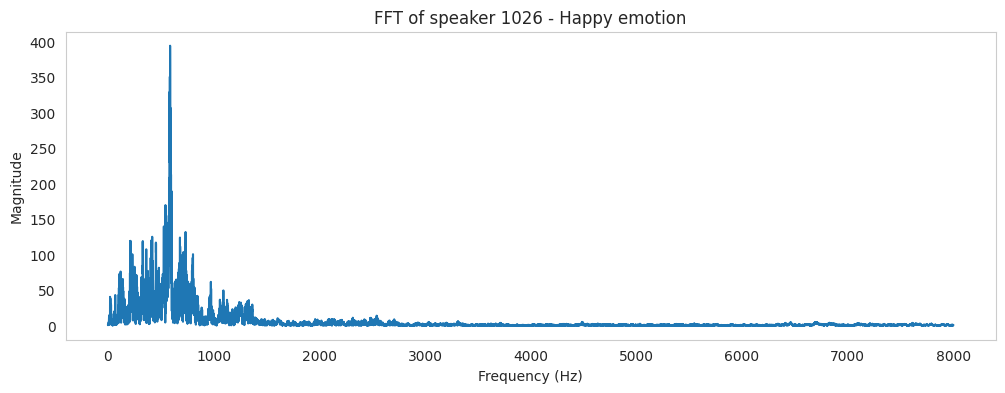

Speaker 1026:


In [22]:
# Compare two different speakers saying "happy"
happy_files = df[df['emotion'] == 'HAP']['filename'].values[:5]

for i, hf in enumerate(happy_files[:2]):
    sr_comp, samples_comp = wavfile.read(audio_path + hf)
    xf, vals = custom_fft(samples_comp, sr_comp)
    
    plt.figure(figsize=(12, 4))
    plt.title(f'FFT of speaker {parse_filename(hf)["actor_id"]} - Happy emotion')
    plt.plot(xf, vals)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.show()
    
    print(f'Speaker {parse_filename(hf)["actor_id"]}:')
    display(ipd.Audio(audio_path + hf))

## 12. Build Simple Classification Model

In [23]:
# Extract features for classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Extracting audio features...")
print("This may take a few minutes...\n")

features_list = []
labels_list = []

# Sample files for faster processing
sample_size = 500
sample_files = audio_files[:sample_size]

for idx, wav_file in enumerate(sample_files):
    if idx % 10 == 0:
        print(f"Processing file {idx + 1}/{len(sample_files)}...")
    
    try:
        # Read audio file
        sr, samples_feat = wavfile.read(audio_path + wav_file)
        
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=samples_feat.astype(float), sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)
        
        # Extract additional features
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=samples_feat.astype(float), sr=sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=samples_feat.astype(float), sr=sr))
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(samples_feat.astype(float)))
        
        # Combine features
        feature_vector = np.hstack([mfccs_mean, mfccs_std, spectral_centroid, spectral_rolloff, zero_crossing_rate])
        features_list.append(feature_vector)
        
        # Get label
        emotion = parse_filename(wav_file)['emotion']
        labels_list.append(emotion)
    except Exception as e:
        continue

features_array = np.array(features_list)
labels_array = np.array(labels_list)

print(f"\n✓ Feature extraction completed!")
print(f"Features shape: {features_array.shape}")
print(f"Number of samples: {len(labels_array)}")

Extracting audio features...
This may take a few minutes...

Processing file 1/500...
Processing file 11/500...
Processing file 21/500...
Processing file 31/500...
Processing file 41/500...
Processing file 51/500...
Processing file 61/500...
Processing file 71/500...
Processing file 81/500...
Processing file 91/500...
Processing file 101/500...
Processing file 111/500...
Processing file 121/500...
Processing file 131/500...
Processing file 141/500...
Processing file 151/500...
Processing file 161/500...
Processing file 171/500...
Processing file 181/500...
Processing file 191/500...
Processing file 201/500...
Processing file 211/500...
Processing file 221/500...
Processing file 231/500...
Processing file 241/500...
Processing file 251/500...
Processing file 261/500...
Processing file 271/500...
Processing file 281/500...
Processing file 291/500...
Processing file 301/500...
Processing file 311/500...
Processing file 321/500...
Processing file 331/500...
Processing file 341/500...
Proce

## 13. Train Model

In [24]:
# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels_array)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    features_array, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Train Random Forest classifier
print("\nTraining Random Forest classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✓ Model trained!")
print(f"Test Accuracy: {accuracy:.2%}")

Training set size: 400
Test set size: 100

Training Random Forest classifier...

✓ Model trained!
Test Accuracy: 36.00%


## 14. Evaluate Model

Classification Report:
              precision    recall  f1-score   support

         ANG       0.67      0.59      0.62        17
         DIS       0.11      0.11      0.11        18
         FEA       0.57      0.42      0.48        19
         HAP       0.21      0.24      0.22        17
         NEU       0.12      0.15      0.14        13
         SAD       0.59      0.62      0.61        16

    accuracy                           0.36       100
   macro avg       0.38      0.36      0.36       100
weighted avg       0.39      0.36      0.37       100



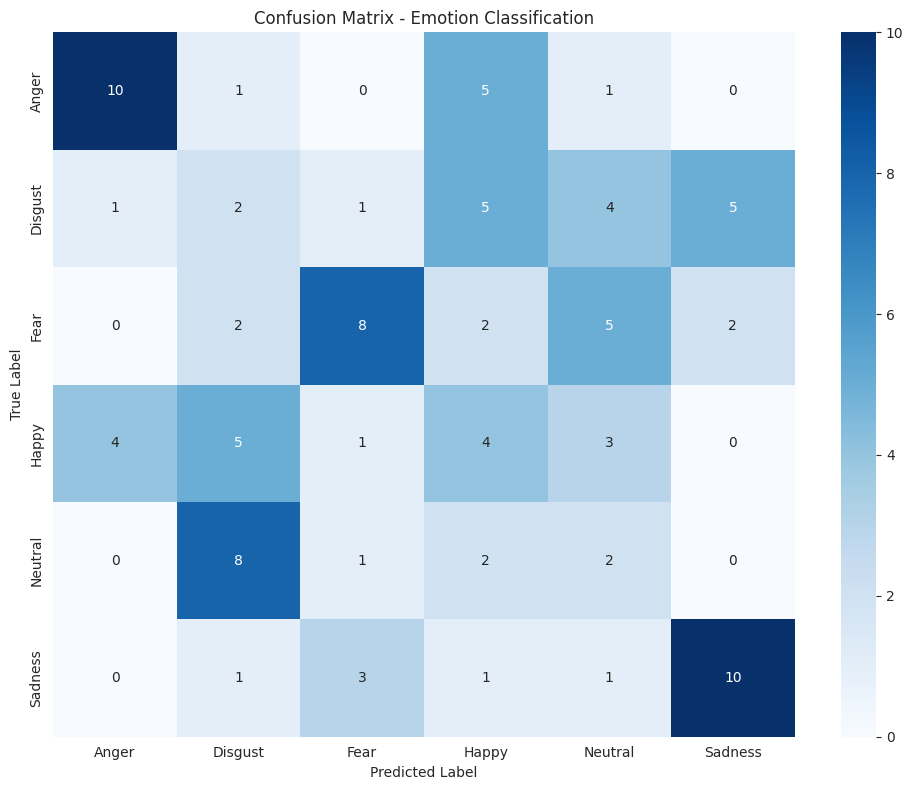

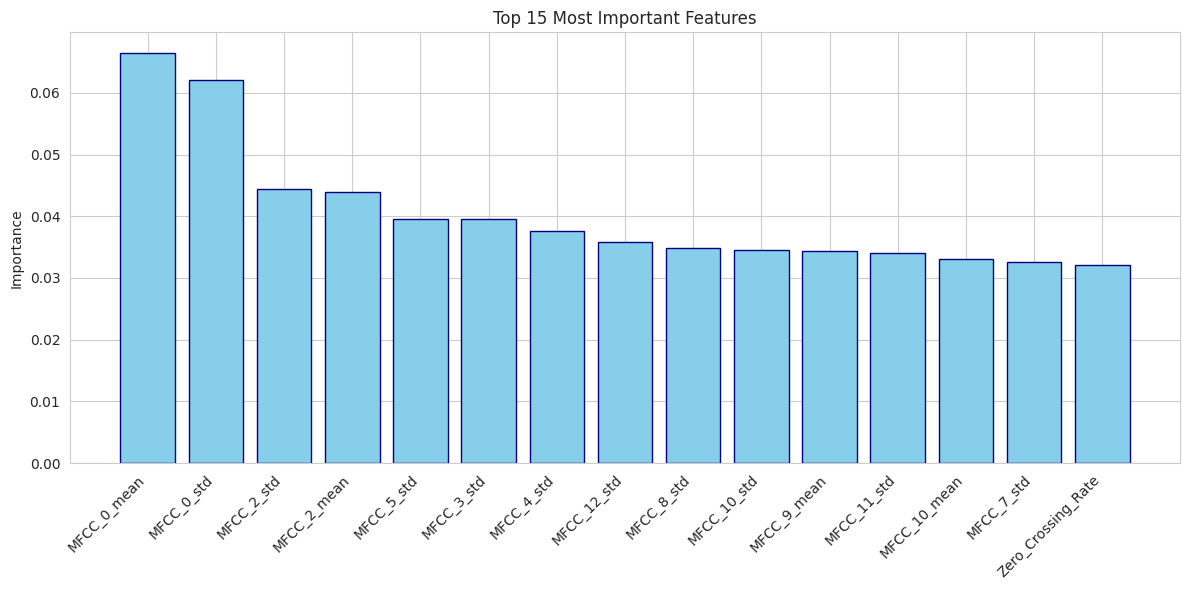

In [25]:
# Classification report
print("Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[emotion_names[e] for e in le.classes_],
            yticklabels=[emotion_names[e] for e in le.classes_])
plt.title('Confusion Matrix - Emotion Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Feature importance
feature_names = ([f'MFCC_{i}_mean' for i in range(13)] + 
                 [f'MFCC_{i}_std' for i in range(13)] + 
                 ['Spectral_Centroid', 'Spectral_Rolloff', 'Zero_Crossing_Rate'])

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(12, 6))
plt.title('Top 15 Most Important Features')
plt.bar(range(15), importances[indices], color='skyblue', edgecolor='navy')
plt.xticks(range(15), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

## 15. Save Model

In [26]:
import joblib

# Save model and label encoder
model_path = '../models/speech_emotion_model.pkl'
encoder_path = '../models/speech_emotion_encoder.pkl'

joblib.dump(rf_model, model_path)
joblib.dump(le, encoder_path)

print(f"✓ Model saved to: {model_path}")
print(f"✓ Label encoder saved to: {encoder_path}")

# Save metadata
metadata = {
    'model_type': 'Random Forest',
    'n_estimators': 100,
    'features': feature_names,
    'n_features': features_array.shape[1],
    'n_samples': len(labels_array),
    'accuracy': accuracy,
    'emotions': list(le.classes_),
    'dataset': 'CREMA-D',
    'timestamp': '2026-01-21'
}

metadata_path = '../models/speech_emotion_metadata.pkl'
joblib.dump(metadata, metadata_path)
print(f"✓ Metadata saved to: {metadata_path}")

print("\n" + "=" * 60)
print("MODEL SUMMARY")
print("=" * 60)
for key, value in metadata.items():
    if key != 'features':
        print(f"{key:20s}: {value}")
print("=" * 60)
print("\nModel can classify 6 emotions: Anger, Disgust, Fear, Happy, Neutral, Sadness")
print("Features used: MFCC (mean + std), Spectral Centroid, Spectral Rolloff, Zero Crossing Rate")

✓ Model saved to: ../models/speech_emotion_model.pkl
✓ Label encoder saved to: ../models/speech_emotion_encoder.pkl
✓ Metadata saved to: ../models/speech_emotion_metadata.pkl

MODEL SUMMARY
model_type          : Random Forest
n_estimators        : 100
n_features          : 29
n_samples           : 500
accuracy            : 0.36
emotions            : [np.str_('ANG'), np.str_('DIS'), np.str_('FEA'), np.str_('HAP'), np.str_('NEU'), np.str_('SAD')]
dataset             : CREMA-D
timestamp           : 2026-01-21

Model can classify 6 emotions: Anger, Disgust, Fear, Happy, Neutral, Sadness
Features used: MFCC (mean + std), Spectral Centroid, Spectral Rolloff, Zero Crossing Rate
